In [2]:
import tensorflow as tf
# Enable this line of code if you're not using Tensorflow 2.3  #################### IMPORTANT ##################
#tf.enable_eager_execution()
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gym
from base_environment import BaseEnvironment
from base_agent import BaseAgent
from rl_glue import RLGlue
import json
from ast import literal_eval
import time
from IPython.display import clear_output
#%matplotlib notebook

In [3]:
class ReplayBuffer:
    def __init__(self, size, batch_size, seed):
        """Initialize buffer paremeters"""
        self.buffer = {
            'states': [],
            'actions': [],
            'rewards': [],
            'terminals': [],
            'next_states': []
        }
        self.batch_size = batch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """Append an experience"""
        if len(self.buffer['states']) == self.max_size:
            del self.buffer['states'][0]
            del self.buffer['actions'][0]
            del self.buffer['rewards'][0]
            del self.buffer['terminals'][0]
            del self.buffer['next_states'][0]
        self.buffer['states'].append(state)
        self.buffer['actions'].append(action)
        self.buffer['rewards'].append(reward)
        self.buffer['terminals'].append(terminal)
        self.buffer['next_states'].append(next_state)
        
    def sample(self):
        """Returns a list of transition tuples including state, action, reward, terinal, and next_state"""
        indices = self.rand_generator.choice(np.arange(len(self.buffer['states'])), size=self.batch_size)
        return {
            'states': [self.buffer['states'][i] for i in indices],
            'actions': [self.buffer['actions'][i] for i in indices],
            'rewards': [self.buffer['rewards'][i] for i in indices],
            'terminals': [self.buffer['terminals'][i] for i in indices],
            'next_states': [self.buffer['next_states'][i] for i in indices]
        }
    
    def size(self):
        return len(self.buffer['states'])

In [4]:
class ExpectedSarsaNetwork(tf.keras.Model):
    def __init__(self, network_config):
        super(ExpectedSarsaNetwork, self).__init__()
        self.model_file = network_config['model_file']
        self.dense1 = keras.layers.Dense(network_config['num_hidden_units'], input_dim=network_config['state_dim'], activation='relu')
        self.dense2 = keras.layers.Dense(network_config['num_hidden_units'], activation='relu')
        #self.dense3 = keras.layers.Dense(network_config['num_hidden_units'], activation='relu')
        self.outputa = keras.layers.Dense(network_config['num_actions'], activation=None)
    
    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        #x = self.dense3(x)
        x = self.outputa(x)
        return x

In [5]:
"""""""""""""""""""""""""""""""""""""""HELPER SOFTMAX AND ARGMAX FUNCTIONS"""""""""""""""""""""""""""""""""""""""
def softmax_policy(action_values, tau=1.0):
    """Compute softmax probabilities from action values"""
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = action_values / tau
    # Compute the maximum preference across the actions
    max_preference = np.max(action_values, axis=1) /tau
    # Reshape max_preference array which has shape [Batch,] to [Batch, 1] (allow broadcast)
    max_preference = max_preference.reshape((-1, 1))
    # Compute the exponential of the preference - the max preference.
    exp_preferences = np.exp(preferences - max_preference)
    # Compute the sum over the numerator along the actions axis.
    exp_preferences_sum = np.sum(exp_preferences, axis=1)    
    # Reshape exp_preferences_sum array which has shape [Batch,] to [Batch, 1] (allow broadcast)
    exp_preferences_sum = exp_preferences_sum.reshape((-1, 1))
    # Compute the action probabilities
    action_probabilities = exp_preferences / exp_preferences_sum
    # Removes any singleton dimensions
    action_probabilities = action_probabilities.squeeze()
    # Replace any unnoticed NaNs with 0
    where_are_NaNs = np.isnan(action_probabilities)
    action_probabilities[where_are_NaNs] = 0
    # Returning the action probabilities
    return action_probabilities

def argmax(action_values, random_generator):
    """argmax with random tie breaking"""
    return np.random.choice(np.flatnonzero(action_values == action_values.max()))

In [82]:
class ExpectedSarsaAgent(BaseAgent):
    """Implements the agent for an RL-Glue environment""" 
    def __init__(self):
        self.name = "expected_sarsa_agent"

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        # Number of actions
        self.num_actions = agent_info['network_config']['num_actions']
        # Number of experience replay steps
        self.num_replay = agent_info['num_replay_updates_per_step']
        # Discount factor
        self.discount = agent_info['gamma']
        # Tau the temperature parameter used in the softmax policy
        self.tau = agent_info['tau']
        # Discount factor
        self.step_size = agent_info['optimizer_config']['step_size']
        # A random  generator used with a knowen seed
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        # Replay Buffer used instead of a learned model
        self.replay_buffer = ReplayBuffer(agent_info['replay_buffer_size'], 
                                          agent_info['batch_size'], agent_info.get("seed"))
        
        # Defining the using_softmax_policy parameter
        self.using_softmax_policy = agent_info['using_softmax_policy']
        # Check if using the e greedy action selection
        if self.using_softmax_policy:
            # Tau the temperature parameter used in softmax action selection
            self.tau = agent_info['tau']
        else:
            # Epsilon for E-Greedy action selection
            self.e_greedy_m = agent_info['e_greedy_m']
            self.e_greedy_min = agent_info['e_greedy_min']
            self.e_greedy_epsilon = ((self.e_greedy_min - 1) / self.e_greedy_m) * 1 + 1
            
        

        # Initialize the evaluation network
        self.target_evaluation_network = ExpectedSarsaNetwork(agent_info['network_config'])

        # Initialize the next network 
        self.network = ExpectedSarsaNetwork(agent_info['network_config'])

        # compile the evaluation network
        self.target_evaluation_network.compile(optimizer=keras.optimizers.Adam(
            lr=self.step_size), loss="mse",metrics=["mse"])
        
        # Call the subclassed model once to create the weights.
        self.target_evaluation_network(tf.ones((agent_info['batch_size'],agent_info['network_config']['state_dim'] )))

        # compile the next nework
        self.network.compile(optimizer=keras.optimizers.Adam(
            lr=self.step_size), loss="mse", metrics=["mse"])
        
        # Initialising paremeters
        self.last_state = None
        self.last_action = None
        
        self.dict_info = {
            'run_info': {
                'softmax_or_e_greedy': '',
                'step-size': -1
            },
            'loss': [],
            'metric': [],
            'episode_steps': [],
            'rewards': [],
            'model': ''
        }
        
    def choose_e_greedy_action(self, observation):
        """Used to choose an action"""
        # Get the action values from the neural network
        observation_tensor = tf.Variable(observation, dtype=tf.float32)
        # Convert action values type from tensors to numpy array
        action_values_tensor = self.network.call(observation_tensor)
        action_values_proto_tensor = tf.make_tensor_proto(action_values_tensor)
        action_values = tf.make_ndarray(action_values_proto_tensor)
        # Check the value of epsilon
        if np.random.random() < self.e_greedy_epsilon:
            return  np.random.choice([i for i in range(len(action_values))])
        else:
            return argmax(action_values, self.rand_generator)
    
    def choose_softmax_action(self, observation):
        """Used to choose an action"""
        # Create a tensor variable
        observation_tensor = tf.Variable(observation, dtype=tf.float32)
        # Get the action values from the neural network
        action_values_tensor = self.network.call(observation_tensor)
        # Convert action values type from tensors to numpy array
        action_values_proto_tensor = tf.make_tensor_proto(action_values_tensor)
        action_values = tf.make_ndarray(action_values_proto_tensor)
        # Get the actions probabilities from the softmax using action values
        probs_batch = softmax_policy(action_values, self.tau)
        # Choosing an action using the probability distribution generated by the softmax policy
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        # returning the chosen action
        return action
        
    def agent_start(self, observation):
        """The first method called when the experiment starts"""
        # Setting the last state 
        self.last_state = np.array([observation])
        
#         if len(self.dict_info['episode_steps']) == 200:
#             self.tau = 0.000001
        
        # check for softmax or e_greedy
        if self.using_softmax_policy:
            # Setting the last action using the softmax policy method
            self.last_action = self.choose_softmax_action(self.last_state)
        else:
            # Setting the last action using the epsilon greedy policy method
            self.last_action = self.choose_e_greedy_action(self.last_state)
        # Add an element to dict_info['rewards'] list
        self.dict_info['rewards'].append(0)
        # Add an element to dict_info['episode_steps'] list
        self.dict_info['episode_steps'].append(0)
        # Returing the last action
        return self.last_action

    
    def agent_step(self, reward, observation):
        """A step taken by the agent"""
        # convert the observation to a numpy array
        state = np.array([observation])
        # check for softmax or e_greedy
        if self.using_softmax_policy:
            # selecting the action using the softmax policy 
            action = self.choose_softmax_action(state)
        else:
            # Applying Annealling e_greedy_epsilon equation (len(self.dict_info['episode_steps']) == number of episodes)
            update = ((self.e_greedy_min - 1) / self.e_greedy_m) * len(self.dict_info['episode_steps']) + 1
            if update > self.e_greedy_min:
                self.e_greedy_epsilon = update
            else:
                self.e_greedy_epsilon = self.e_greedy_min
            # selecting the action using the epsilon greedy policy
            action = self.choose_e_greedy_action(state)
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        # Perform replay steps
        if self.replay_buffer.size() > self.replay_buffer.batch_size:
            # Copy the network weights to the target_evaluation_network
            self.target_evaluation_network.set_weights(self.network.get_weights())
            # For each replay step
            for _ in range(self.num_replay):
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                # Converting experiences to numpy arrays
                states = np.array(experiences['states']).squeeze()
                actions = np.array(experiences['actions']).squeeze()
                rewards = np.array(experiences['rewards']).squeeze()
                terminals = np.array(experiences['terminals']).squeeze()
                next_states = np.array(experiences['next_states']).squeeze()
                # Reshaping rewards and terminals to [batch-size, 1], to broadcast operations
                rewards = rewards.reshape((-1, 1))
                terminals = terminals.reshape((-1, 1))
                # Compute action values at current states using network
                td_target = self.network(states).numpy()
                # Compute action values at next states using target_evaluation_network
                q_target_matrix = self.target_evaluation_network(next_states).numpy()
                # check for softmax or e_greedy
                if self.using_softmax_policy:
                    # Compute policy probabilities at next state by passing the action-values to softmax_policy()    
                    probabilities_matrix = softmax_policy(q_target_matrix, self.tau)
                else:
                    # Compute actions probabilities in the case of EPSILON GREEDY ACTION SELECTION
                    q_max = np.max(q_target_matrix, axis=1).reshape((-1, 1))
                    probabilities_matrix = np.ones_like(q_target_matrix) * (self.e_greedy_epsilon / self.num_actions)
                    for i in range(probabilities_matrix.shape[0]):
                        probabilities_matrix[i] += (q_target_matrix[i] == q_max[i]) * ((1 - self.e_greedy_epsilon) / np.sum(q_target_matrix[i] == q_max[i]))
                # Compute the estimate of the next state value, v_target_vector
                # NOTE: this line is the only difference between Expected Sarsa and Q-learning
                # Changing this line from the sum of (next q-values * their probabilities) 
                # to the maximum q-value will just make it Q-Learning
                v_target_vector = np.sum(q_target_matrix * probabilities_matrix, axis=1).reshape((-1, 1)) * (1 - terminals) 
                # Q-learning
                #v_target_vector = np.max(q_target_matrix, axis=1) * (1 - terminals)
                # Compute Expected Sarsa target 
                targets = rewards + self.discount * v_target_vector
                for i in range(terminals.shape[0]):
                    td_target[i, actions[i]] = targets[i]
                # Training the network using the batch of (states, TD_target)
                r = self.network.train_on_batch(states, td_target)
                # Saving loss and metric to dict info
                self.dict_info['loss'].append(r[0])
                self.dict_info['metric'].append(r[1])
                
        # Update the last state
        self.last_state = state
        # Update the last action
        self.last_action = action
        # Adding the last step resulting reward to dict_info['rewards']
        self.dict_info['rewards'][-1] += reward
        # Adding an episode step
        self.dict_info['episode_steps'][-1] += 1
        # Return the selected action
        return action
    
    def agent_end(self, reward):
        """The final step taken by the agent"""
        # Setting the state as an array of zeros
        state = np.zeros_like(self.last_state)
        # Check for softmax or e_greedy
        if not self.using_softmax_policy:
            # Applying Annealling e_greedy_epsilon equation (len(self.dict_info['episode_steps']) == number of episodes)
            update = ((self.e_greedy_min - 1) / self.e_greedy_m) * len(self.dict_info['episode_steps']) + 1
            if update > self.e_greedy_min:
                self.e_greedy_epsilon = update
            else:
                self.e_greedy_epsilon = self.e_greedy_min
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.batch_size:
            # Copy the neural network ???
            self.target_evaluation_network.set_weights(self.network.get_weights())
            # For each replay step
            for _ in range(self.num_replay):
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                # Converting experiences to numpy arrays
                states = np.array(experiences['states']).squeeze()
                actions = np.array(experiences['actions']).squeeze()
                rewards = np.array(experiences['rewards']).squeeze()
                terminals = np.array(experiences['terminals']).squeeze()
                next_states = np.array(experiences['next_states']).squeeze()
                # Reshaping rewards and terminals to [batch-size, 1], to broadcast operations
                rewards = rewards.reshape((-1, 1))
                terminals = terminals.reshape((-1, 1))
                # Compute action values at current states using network
                td_target = self.network(states).numpy()
                # Compute action values at next states using target_evaluation_network
                q_target_matrix = self.target_evaluation_network(next_states).numpy()
                # check for softmax or e_greedy
                if self.using_softmax_policy:
                    # Compute policy probabilities at next state by passing the action-values to softmax_policy()   
                    probabilities_matrix = softmax_policy(q_target_matrix, self.tau)
                else:
                    # Compute actions probabilities in the case of EPSILON GREEDY ACTION SELECTION
                    q_max = np.max(q_target_matrix, axis=1).reshape((-1, 1))
                    probabilities_matrix = np.ones_like(q_target_matrix) * (self.e_greedy_epsilon / self.num_actions)
                    for i in range(probabilities_matrix.shape[0]):
                        probabilities_matrix[i] += (q_target_matrix[i] == q_max[i]) * ((1 - self.e_greedy_epsilon) / np.sum(q_target_matrix[i] == q_max[i]))
                # Compute the estimate of the next state value, v_target_vector
                # NOTE: this line is the only difference between Expected Sarsa and Q-learning
                # Changing this line from the sum of (next q-values * their probabilities) 
                # to the maximum q-value will just make it Q-Learning
                v_target_vector = np.sum(q_target_matrix * probabilities_matrix, axis=1).reshape((-1, 1)) * (1 - terminals) 
                # Q-learning
                #v_target_vector = np.max(q_target_matrix, axis=1) * (1 - terminals)
                # Compute Expected Sarsa target 
                targets = rewards + self.discount * v_target_vector
                for i in range(terminals.shape[0]):
                    td_target[i, actions[i]] = targets[i]
                # Training the network using the batch of (states, TD_target)
                r = self.network.train_on_batch(states, td_target)
                # Saving loss and metric to dict info
                self.dict_info['loss'].append(r[0])
                self.dict_info['metric'].append(r[1])
                
        
        
        # Adding the last step resulting reward to dict_info['rewards']
        self.dict_info['rewards'][-1] += reward
        # Adding an episode step
        self.dict_info['episode_steps'][-1] += 1
        
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment"""
        if message == "get_dict_info":
            return self.dict_info
        elif message == "get_model":
            return self.network
        elif message == "get_episode_reward":
            return self.dict_info['rewards'][-1]
        
        else:
            raise Exception("Unrecognized Message!")
    

In [83]:
class LunarLanderEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts"""
        # Initialize env to LunarLander-v2
        self.env = gym.make(env_info['environment_name'])
        # Set a random seed, 
        # NOTE: this is important if we want to do tests for multiple algorithms 
        # or multiple algorithm parameters. 
        self.env.seed(0)

    def env_start(self):
        """The first method called when the experiment starts"""
        # Get Initial State
        observation = self.env.reset()
        # Return the initial state from the environment
        return observation
        
    def env_step(self, action):
        """A step taken by the environment"""
        #self.env.render()
        # Get state, reward and terminal from the environment
        state, reward, terminal, _ = self.env.step(action)
        # Return the reward, state and terminal to the RL Glue
        return (reward, state, terminal)
    def env_cleanup(self):
        """Cleanup done after the environment ends"""
        #self.env.close()

In [84]:
"""""""""""""""""""""""""""""""""""""""HELPER LOAD, PARSE and PLOT FUNCTIONS"""""""""""""""""""""""""""""""""""""""
def parse_loaded_data(load):
    load['loss'] = literal_eval(load['loss'])
    load['metric'] = literal_eval(load['metric'])
    load['rewards'] = literal_eval(load['rewards'])
    load['loss'] = [float(i) for i in load['loss']]
    load['metric'] = [float(i) for i in load['metric']]
    load['rewards'] = [float(i) for i in load['rewards']]
    return load

def load_data(loaded, data_name):
    if data_name == 'batch_size_and_replay_steps':
        for i in range(len(agent_info['batch_sizes'])): 
            for j in range(len(agent_info['replays_steps'])):
                with open('.\\results\\batch_size_and_replay_steps\\data_softmax_b' + str(i) + '_ns' + str(j) + '.json') as file: 
                    loaded['batch_size_and_replay_steps'].append(parse_loaded_data(json.load(file)))
    elif data_name == 'e_greedy_and_softmax':
        for i in range(len(experiment_info['tau_values'])): 
            for j in range(len(experiment_info['step_sizes'])):
                with open('.\\results\\e_greedy_and_softmax\\data_softmax_t' + str(i) + '_s' + str(j) + '.json') as file: 
                    loaded['softmax_tau_step_size'].append(parse_loaded_data(json.load(file)))
        for i in range(len(experiment_info['e_greedy_m_values'])): 
            for j in range(len(experiment_info['step_sizes'])):
                with open('.\\results\\e_greedy_and_softmax\\data_e_greedy_e' + str(i) + '_s' + str(j) + '.json') as file: 
                    loaded['e_greedy_epsilon_step_size'].append(parse_loaded_data(json.load(file)))
    elif data_name == 'best_model_data':
        with open('.\\results\\best_model\\data_softmax.json') as file: 
            loaded['best_model_data'] = parse_loaded_data(json.load(file))
    
def reconstruct_model(path):
    # Initialize the network
    network = ExpectedSarsaNetwork(agent_info['network_config'])
    # compile the network
    network.compile(optimizer=keras.optimizers.Adam(
        lr=agent_info['optimizer_config']['step_size']), loss="mse",metrics=["mse"])
    # Call the subclassed model once to create the weights.
    network.call(tf.ones((agent_info['batch_size'],agent_info['network_config']['state_dim'] )))
    # Set the weights of the neural network
    network.load_weights(path)
    # Return the network
    return network

def compute_average(data):
    for i in range(len(data)):
        data[i]['average_loss'] = np.sum(np.array(data[i]['loss'])) / len(data[i]['loss'])
        data[i]['average_metric'] = np.sum(np.array(data[i]['metric'])) / len(data[i]['metric'])
        data[i]['average_reward'] = np.sum(np.array(data[i]['rewards'])) / len(data[i]['rewards'])
        

def moving_average(a, n=10) :
    """Moving Average or (Sliding window) used to make the plot smoother"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

    
def plot(data, run_info, data_name, only_smoothed, smoothing_step, title, x_label, y_label, fig_size=(13,4), ylim=False, ylim_val=[0, 10], clear=False):
    if clear:
        plt.clf
        clear_output(wait=True)
    if data_name == 'batch_size_and_replay_steps':
        print('batch size :', run_info['batch'], ', replay steps :', run_info['num_steps'])
        print()
    elif data_name == 'softmax_tau_step_size':
        print('tau :', run_info['tau'], ', step size :', run_info['step_size'])
        print()
    elif data_name == 'e_greedy_epsilon_step_size':
        print('e greedy M :', run_info['epsilon'], ', step size :', run_info['step_size'])
        print()
    if only_smoothed == 0 or only_smoothed == 2:
        plt.figure(figsize=fig_size)
        plt.title(title, fontsize = 15)
        plt.xlabel(x_label, fontsize = 14)
        plt.ylabel(y_label, rotation=0, labelpad=40, fontsize = 14)
        if ylim == True:
            plt.ylim(ylim_val)
        plt.plot(data)
        plt.show() 
    elif only_smoothed == 1 or only_smoothed == 2:
        plt.figure(figsize=(12,4))
        plt.title(title, fontsize = 15)
        plt.xlabel(x_label, fontsize = 14)
        plt.ylabel(y_label, rotation=0, labelpad=40, fontsize = 14)
        smoothed_data = moving_average(data, smoothing_step)
        plt.plot(smoothed_data)
        plt.show()  
        
    
def plot_same_type(data_type, data_name, only_smoothed):
    print('Number of test instances :', len(loaded[data_name]))
    print()
    if data_type == 'loss':
        for i in range(len(loaded[data_name])):
            game = loaded[data_name][i]
            plot(game['loss'], game['run_info'], data_name, only_smoothed, 50000, 'Loss of '+ data_name, 'steps', 'Loss')
    elif data_type == 'rewards':
        for i in range(len(loaded[data_name])):
            game = loaded[data_name][i]
            plot(game['rewards'], game['run_info'], data_name, only_smoothed, 30, 'Reward of '+ data_name, 'Episodes', 'rewards')
    elif data_type == 'episode_steps':
        for i in range(len(loaded[data_name])):
            game = loaded[data_name][i]
            plot(game['episode_steps'], game['run_info'], data_name, only_smoothed, 100, 'Number of steps in each episode of '+ data_name, 'Episodes', 'num_steps')
    elif data_type == 'metric':
        for i in range(len(loaded[data_name])):
            game = loaded[data_name][i]
            plot(game['metric'], game['run_info'], data_name, only_smoothed, 50000, 'Learning Curve', 'steps', 'metric')
            

In [85]:
"""""""""""""""""""""""Testing e_greedy and softmax"""""""""""""""""""""""""""
def run_experiment(environment, agent, runs_info, environment_parameters, agent_parameters, experiment_parameters):
    # Instantiate an RLGlue Object
    rl_glue = RLGlue(environment, agent)
    
    # Setting the run random seeds to get consistent results each time we do an experement
    agent_parameters["seed"] = 1
    agent_parameters["network_config"]["seed"] = 1
    environment_parameters["seed"] = 1
    
    ######################## E_GREEDY ########################
    agent_parameters['using_softmax_policy'] = False
    print('E-greedy action selection')
    for i, e_greedy_m in enumerate(experiment_parameters['e_greedy_m_values']): 
        for j, step_size in enumerate(experiment_parameters['step_sizes']):
            agent_parameters['e_greedy_m'] = e_greedy_m
            agent_parameters['optimizer_config']['step_size'] = step_size
            # Initialize the RLGlue Object
            rl_glue.rl_init(agent_parameters, environment_parameters)
            # For each episode
            for episode in tqdm(range(experiment_parameters["num_episodes"])):
                # Call an RLGlue episode
                rl_glue.rl_episode(experiment_parameters["timeout"])

            # Getting dict_info using agent_message function
            runs_info.append(rl_glue.rl_agent_message("get_dict_info"))
            # Appending to runs_info the info of this run
            runs_info[-1]['run_info']['softmax_or_e_greedy'] = 'e_greedy'
            runs_info[-1]['run_info']['epsilon'] = str(e_greedy_m)
            runs_info[-1]['run_info']['step_size'] = str(step_size)
            runs_info[-1]['rewards'] = str(runs_info[-1]['rewards'])
            runs_info[-1]['loss'] = str(runs_info[-1]['loss'])
            runs_info[-1]['metric'] = str(runs_info[-1]['metric'])
            # Save runs_info in a text file
            with open('.\\tests\\test1\\data_e_greedy_e' + str(i) + '_s' + str(j) + '.json', 'w') as file:
                json.dump(runs_info[-1], file)
            # Getting the model using agent_message
            model = rl_glue.rl_agent_message("get_model") 
            # Saving the weights of the model in a file
            model.save_weights('.\\tests\\test1\\model_e_greedy_e' + str(i) + '_s' + str(j) + '.h5')
            # appending the model to runs_info
            runs_info[-1]['model'] = model

    ######################## SOFTMAX #########################
    agent_parameters['using_softmax_policy'] = True                   
    print('Softmax action selection')
    for i, tau in enumerate(experiment_parameters['tau_values']): 
        for j, step_size in enumerate(experiment_parameters['step_sizes']):
            agent_parameters['tau'] = tau
            agent_parameters['optimizer_config']['step_size'] = step_size
            # Initializing the RLGlue Object
            rl_glue.rl_init(agent_parameters, environment_parameters)
            # For each episode
            for episode in tqdm(range(experiment_parameters["num_episodes"])):
                # Calling an RLGlue episode
                rl_glue.rl_episode(experiment_parameters["timeout"])

            # Getting dict_info using agent_message function
            runs_info.append(rl_glue.rl_agent_message("get_dict_info"))
            # Appending to runs_info the info of this run
            runs_info[-1]['run_info']['softmax_or_e_greedy'] = 'softmax'
            runs_info[-1]['run_info']['tau'] = str(tau)
            runs_info[-1]['run_info']['step_size'] = str(step_size)
            runs_info[-1]['rewards'] = str(runs_info[-1]['rewards'])
            runs_info[-1]['loss'] = str(runs_info[-1]['loss'])
            runs_info[-1]['metric'] = str(runs_info[-1]['metric'])

            # Save runs_info in a text file
            with open('.\\tests\\test2\\data_softmax_t' + str(i) + '_s' + str(j) + '.json', 'w') as file:
                json.dump(runs_info[-1], file)
            # Getting the model using agent_message
            model = rl_glue.rl_agent_message("get_model") 
            # Saving the weights of the model in a file
            model.save_weights('.\\tests\\test2\\model_softmax_t' + str(i) + '_s' + str(j) + '.h5')
            # appending the model to runs_info
            runs_info[-1]['model'] = model

In [86]:
"""""""""""""""""""""""Testing Batch Size and Replay Steps"""""""""""""""""""""""""""
def run_experiment(environment, agent, runs_info, environment_parameters, agent_parameters, experiment_parameters):
    # Instantiate an RLGlue Object
    rl_glue = RLGlue(environment, agent)
    # For each run
    agent_parameters["seed"] = 1
    agent_parameters["network_config"]["seed"] = 1
    environment_parameters["seed"] = 1
    for i, batch in enumerate(agent_parameters['batch_sizes']):
        for j, num_steps in enumerate(agent_parameters['replays_steps']):
            agent_parameters['batch_size'] = batch
            agent_parameters['num_replay_updates_per_step'] = num_steps
            # Initialize the RLGlue Object
            rl_glue.rl_init(agent_parameters, environment_parameters)
            # For each episode
            for episode in tqdm(range(experiment_parameters["num_episodes"])):
                # Call an RLGlue episode
                rl_glue.rl_episode(experiment_parameters["timeout"])
                
            runs_info.append(rl_glue.rl_agent_message("get_dict_info"))
            runs_info[-1]['run_info']['softmax_or_e_greedy'] = 'softmax'
            runs_info[-1]['run_info']['batch'] = str(batch)
            runs_info[-1]['run_info']['num_steps'] = str(num_steps)
            runs_info[-1]['rewards'] = str(runs_info[-1]['rewards'])
            runs_info[-1]['loss'] = str(runs_info[-1]['loss'])
            runs_info[-1]['metric'] = str(runs_info[-1]['metric'])

            # Save dict_info in a text file
            with open('.\\tests\\test3\\data_softmax_b' + str(i) + '_ns' + str(j) + '.json', 'w') as file:
                json.dump(runs_info[-1], file)

            # Getting the model using agent_message
            model = rl_glue.rl_agent_message("get_model") 
            # Saving the weights of the model in a file
            model.save_weights('.\\tests\\test3\\model_softmax_b' + str(i) + '_ns' + str(j) + '.h5')

In [87]:
"""""""""""""""""""""""Normal Run"""""""""""""""""""""""""""
def run_experiment(environment, agent, runs_info, environment_parameters, agent_parameters, experiment_parameters):
    # Instantiate an RLGlue Object
    rl_glue = RLGlue(environment, agent)
    # For each run
    agent_parameters["seed"] = 1
    agent_parameters["network_config"]["seed"] = 1
    environment_parameters["seed"] = 1
    # Initialize the RLGlue Object
    rl_glue.rl_init(agent_parameters, environment_parameters)
    # For each episode
    plot_reward = []
    for episode in tqdm(range(experiment_parameters["num_episodes"])):
        # Call an RLGlue episode
        rl_glue.rl_episode(experiment_parameters["timeout"])
        plot_reward.append(rl_glue.rl_agent_message("get_episode_reward"))
        plot(plot_reward, [], '', 0, 30, 'Reward', 'Episodes', 'Learning Curve', clear=True)
        
    rl_glue.rl_cleanup()
    runs_info.append(rl_glue.rl_agent_message("get_dict_info"))
    runs_info[-1]['run_info']['softmax_or_e_greedy'] = 'softmax'
    runs_info[-1]['run_info']['batch'] = str(8)
    runs_info[-1]['run_info']['num_steps'] = str(8)
    runs_info[-1]['run_info']['tau'] = str(0.01)
    runs_info[-1]['run_info']['step_size'] = str(0.0005)
    runs_info[-1]['rewards'] = str(runs_info[-1]['rewards'])
    runs_info[-1]['loss'] = str(runs_info[-1]['loss'])
    runs_info[-1]['metric'] = str(runs_info[-1]['metric'])
   
    # Save dict_info in a text file
    with open('.\\results\\data_softmax.json', 'w') as file:
        json.dump(runs_info[-1], file)

    # Getting the model using agent_message
    model = rl_glue.rl_agent_message("get_model") 
    # Saving the weights of the model in a file
    model.save_weights('.\\results\\model_softmax.h5')

In [88]:
agent_info = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 128,
        'num_actions': 4,
        'model_file': 'network_model.h5'
    },
    'optimizer_config': {
        'step_size': 0.0005
    },
    'replay_buffer_size': 50000,
    'batch_size': 8,
    'num_replay_updates_per_step': 8,
    'gamma': 0.99,
    'tau': 0.01,
    'e_greedy_m': 20,
    'e_greedy_min': 0.01,
    'using_softmax_policy': True,
    # For parameter tuning
    'batch_sizes': [8,16,32,64,128],
    'replays_steps': [2,4,8,16]
}
experiment_info = {
    'num_episodes' : 3,
    'timeout' : 1000,
    # For parameter tuning
    'tau_values': np.array([0.001, 0.01, 0.1, 1.0]),
    'e_greedy_m_values': np.array([20, 50, 100]),
    'step_sizes': np.array([0.0001, 0.0005, 0.001, 0.01, 0.1])
}
env_info = {
    'environment_name': 'LunarLander-v2'
}
lunar_lander = LunarLanderEnvironment
expected_sarsa_agent = ExpectedSarsaAgent
runs_info = []
# run experiment

run_experiment(lunar_lander, expected_sarsa_agent, runs_info, env_info, agent_info, experiment_info)


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Tensor("dense_59/BiasAdd:0", shape=(1, 4), dtype=float32)
Tensor("Squeeze:0", shape=(4,), dtype=float32)


TypeError: List of Tensors when single Tensor expected

In [25]:
# RECONSTRUCT RUN_INFO
loaded = {
    'batch_size_and_replay_steps': [],
    'softmax_tau_step_size': [],
    'e_greedy_epsilon_step_size': [],
    'best_model_data': ''
}

#load_data(loaded, 'batch_size_and_replay_steps')
#load_data(loaded, 'e_greedy_and_softmax')



In [ ]:
#### COMPUTE AVERAGES ####
compute_average(loaded['batch_size_and_replay_steps'])
compute_average(loaded['softmax_tau_step_size'])
compute_average(loaded['e_greedy_epsilon_step_size'])

Number of test instances : 15

e greedy M : 20 , step size : 0.0001



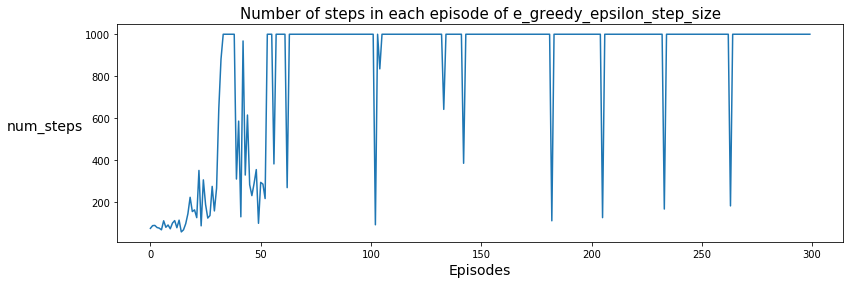

e greedy M : 20 , step size : 0.0005



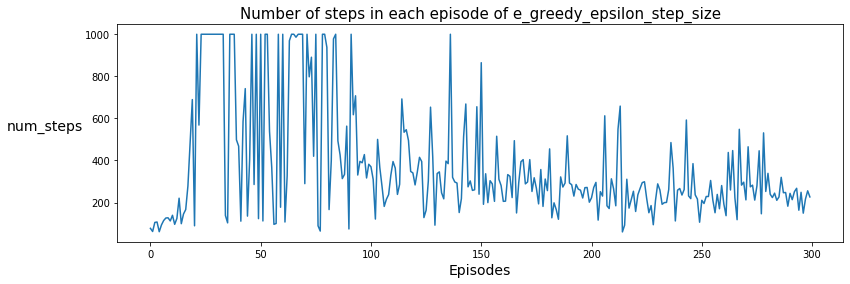

e greedy M : 20 , step size : 0.001



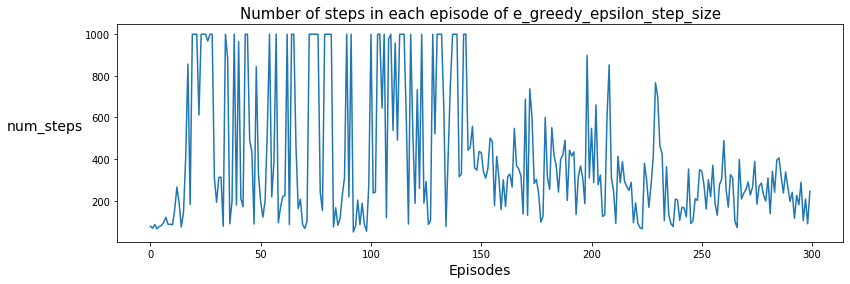

e greedy M : 20 , step size : 0.01



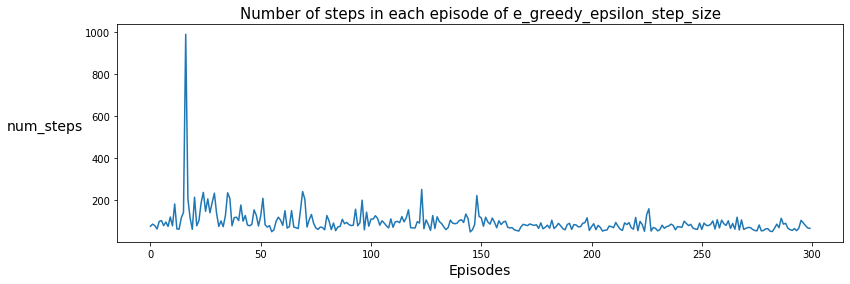

e greedy M : 20 , step size : 0.1



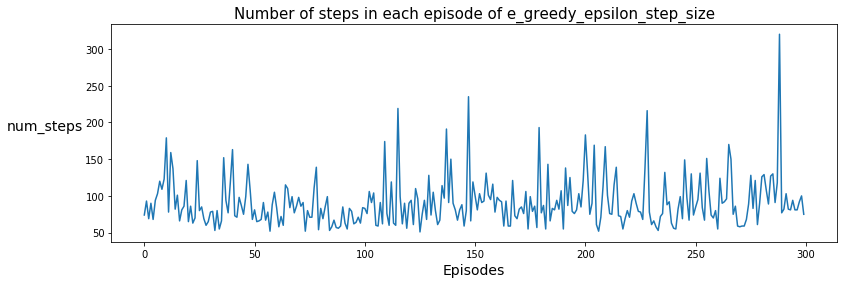

e greedy M : 50 , step size : 0.0001



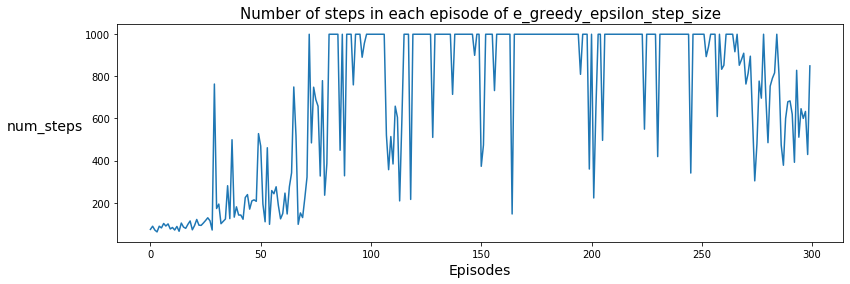

e greedy M : 50 , step size : 0.0005



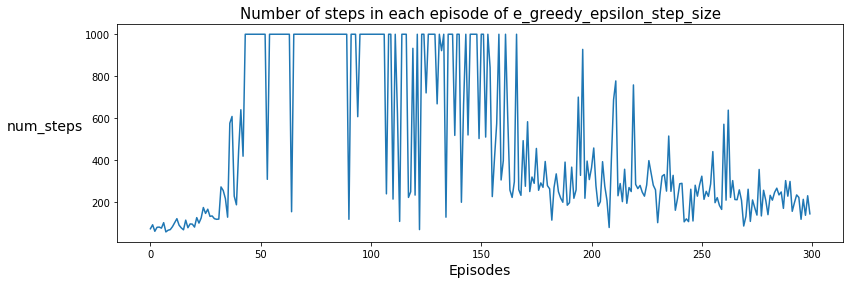

e greedy M : 50 , step size : 0.001



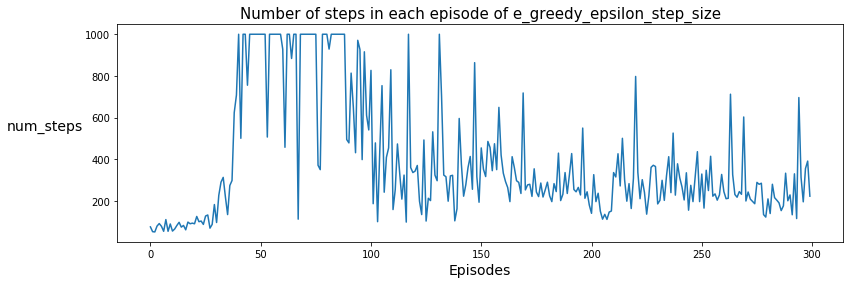

e greedy M : 50 , step size : 0.01



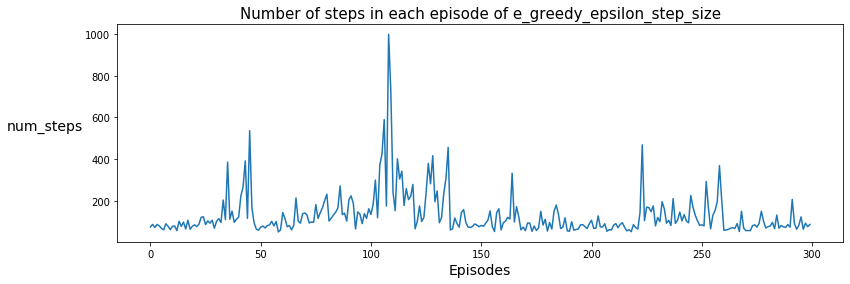

e greedy M : 50 , step size : 0.1



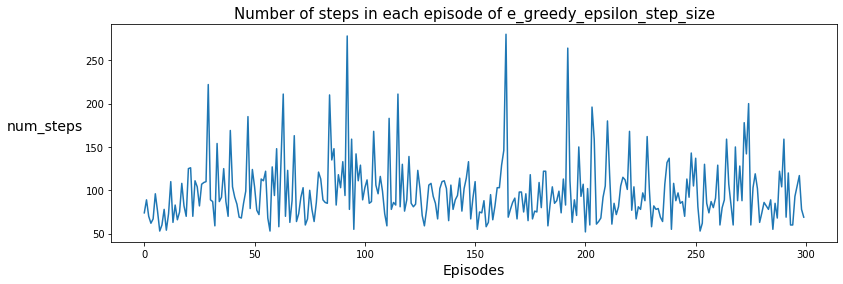

e greedy M : 100 , step size : 0.0001



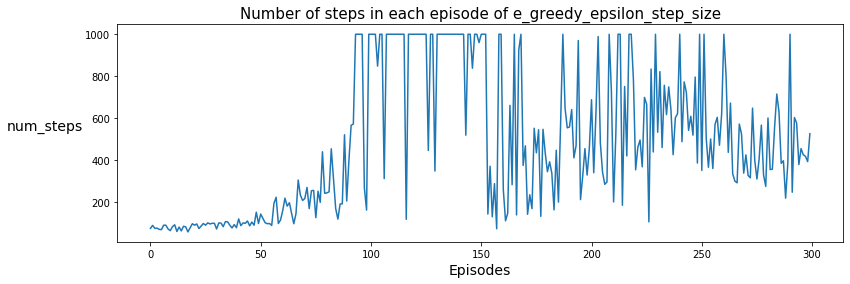

e greedy M : 100 , step size : 0.0005



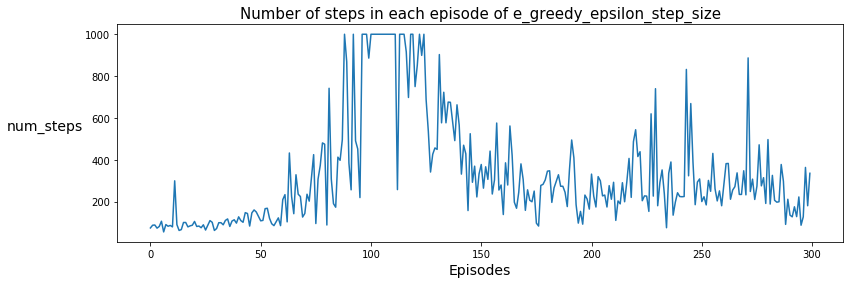

e greedy M : 100 , step size : 0.001



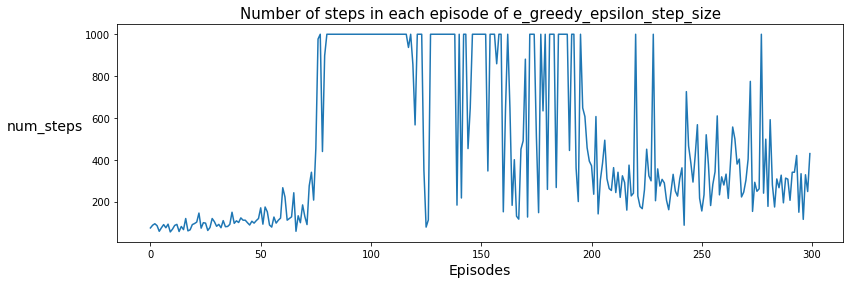

e greedy M : 100 , step size : 0.01



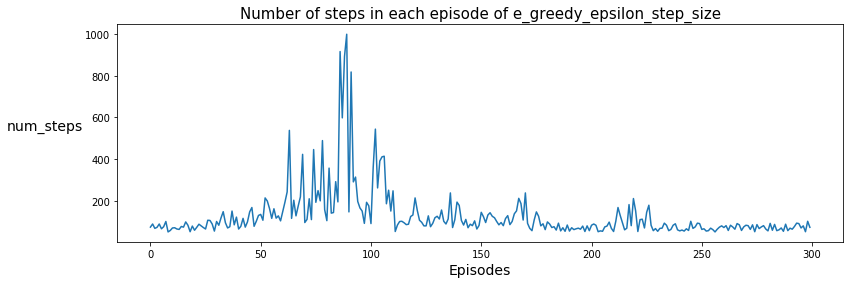

e greedy M : 100 , step size : 0.1



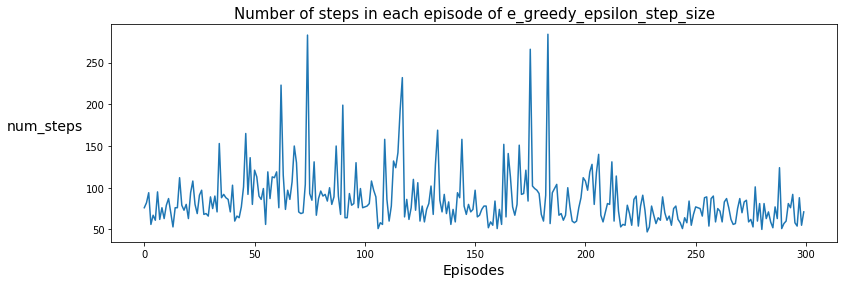

In [28]:
#### PLOT ALL GRAPHS FOR SAME TYPE OF TESTS #####

plot_same_type('rewards', 'batch_size_and_replay_steps', 0)    
#plot_same_type('rewards', 'softmax_tau_step_size', 0)    
#plot_same_type('rewards', 'e_greedy_epsilon_step_size', 0)   

#plot_same_type('loss', 'batch_size_and_replay_steps', 0)    
#plot_same_type('loss', 'softmax_tau_step_size', 0)    
#plot_same_type('loss', 'e_greedy_epsilon_step_size', 0)   

#plot_same_type('episode_steps', 'batch_size_and_replay_steps', 0)    
#plot_same_type('episode_steps', 'softmax_tau_step_size', 0)    
#plot_same_type('episode_steps', 'e_greedy_epsilon_step_size', 0)   

In [ ]:
######################### Choosing the best batch size and number of replay steps ############################
batch_size_and_replay_steps_average_loss = [loaded['batch_size_and_replay_steps'][i]['average_loss'] for i in range(len(loaded['batch_size_and_replay_steps']))]
batch_size_and_replay_steps_average_metric = [loaded['batch_size_and_replay_steps'][i]['average_metric'] for i in range(len(loaded['batch_size_and_replay_steps']))]
batch_size_and_replay_steps_average_rewards = [loaded['batch_size_and_replay_steps'][i]['average_reward'] for i in range(len(loaded['batch_size_and_replay_steps']))]


print('batch_sizes: ', [8,16,32,64,128], ' replays_steps: ', [2,4,8,16])
plot(batch_size_and_replay_steps_average_loss, [], '', 0, 30, 'Average Loss for Bach-Size and Replay-Steps Testing', 'Test Number', 'Average Loss', ylim=True, ylim_val=[0, 10])
#plot(batch_size_and_replay_steps_average_metric, [], '', 0, 30, 'Average Metric', 'Test Number', 'Average Metric')
plot(batch_size_and_replay_steps_average_rewards, [], '', 0, 30, 'Average Reward for Bach-Size and Replay-Steps Testing', 'Test Number', 'Average Reward')

print(batch_size_and_replay_steps_average_loss)
# Best config: batch size : 8 , replay steps : 8 (test number 2) with average reward of 144.92691799377076
#.....  maybe it's not the best because 300 episodes are not enough to decide


In [ ]:
######################### Choosing the best tau and step size in Softmax exploration ############################
softmax_tau_step_size_average_loss = [loaded['softmax_tau_step_size'][i]['average_loss'] for i in range(len(loaded['softmax_tau_step_size']))]
softmax_tau_step_size_average_metric = [loaded['softmax_tau_step_size'][i]['average_metric'] for i in range(len(loaded['softmax_tau_step_size']))]
softmax_tau_step_size_average_rewards = [loaded['softmax_tau_step_size'][i]['average_reward'] for i in range(len(loaded['softmax_tau_step_size']))]

print('tau_values: ', [0.001, 0.01, 0.1, 1.0], ' step_sizes: ', [0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1])
plot(softmax_tau_step_size_average_loss, [], '', 0, 30, 'Average Loss for Tau and Step-Size Testing', 'Test Number', 'Average Loss', ylim=True, ylim_val=[0, 10])
#plot(softmax_tau_step_size_average_metric, [], '', 0, 30, 'Average Metric', 'Test Number', 'Average Metric')
plot(softmax_tau_step_size_average_rewards, [], '', 0, 30, 'Average Reward for Tau and Step-Size Testing', 'Test Number', 'Average Reward')

print(softmax_tau_step_size_average_loss)
# Best config: tau : 0.01 , step size : 0.0005 (test number 6) with average reward of 120.65607773858783
#.....  maybe it's not the best because 300 episodes are not enough to decide

In [ ]:
######################### Choosing the best e_greedy_M and step size in e_greedy exploration ############################
e_greedy_epsilon_step_size_average_loss = [loaded['e_greedy_epsilon_step_size'][i]['average_loss'] for i in range(len(loaded['e_greedy_epsilon_step_size']))]
e_greedy_epsilon_step_size_average_metric = [loaded['e_greedy_epsilon_step_size'][i]['average_metric'] for i in range(len(loaded['e_greedy_epsilon_step_size']))]
e_greedy_epsilon_step_size_average_rewards = [loaded['e_greedy_epsilon_step_size'][i]['average_reward'] for i in range(len(loaded['e_greedy_epsilon_step_size']))]

print('e_greedy_m_values: ', [20, 50, 100], ' step_sizes: ', [0.0001, 0.0005, 0.001, 0.01, 0.1])
plot(e_greedy_epsilon_step_size_average_loss, [], '', 0, 30, 'Average Loss for Epsilon and Step-Size Testing', 'Test Number', 'Average Loss', ylim=True, ylim_val=[0, 10])
#plot(e_greedy_epsilon_step_size_average_metric, [], '', 0, 30, 'Average Metric', 'Test Number', 'Average Metric')
plot(e_greedy_epsilon_step_size_average_rewards, [], '', 0, 30, 'Average Reward for Epsilon and Step-Size Testing', 'Test Number', 'Average Reward')

print(e_greedy_epsilon_step_size_average_loss)
# Best config e greedy M : 50 , step size : 0.001 (test number 7) with average reward of 89.85369241704876
#.....  maybe it's not because 300 episodes are not enough to decide

In [ ]:
###### MUST READ THIS PLEASE ############  IMPORTANT  ############
# We see that the average reward of Softmax exploration (120.65607773858783) is greater than e_greedy
# exploration (89.85369241704876), so we will do the training again using Softmax exploration 
# with these parameters :
# batch size : 8 , replay steps : 8
# tau : 0.01 , step size : 0.0005
# NOTE: these tests that we did were running simultaneously on 2 different computers and 2 different google colab 
# servers (that means 4 computers) took about full 3 days to complete. we did other tests than these but some 
# of them weren't stuctured enough and others were not compleated because google colab servers were constantly 
# failling and our computers weren't enough. we could have gotten much better and precise results if we 
# extended the test period to 500 or 600 episodes.
# NOTE: this is all we could do. we really wated to include more parameters in the tests but it would have taken 
# much longer, so we chose the parameters that we knew they were the most important and impactful on learning process



In [26]:
# The training cell is above
# Load data and model
load_data(loaded, 'best_model_data')
# Reconstruct the Neural network
network = reconstruct_model('.\\results\\best_model\\model_softmax.h5')

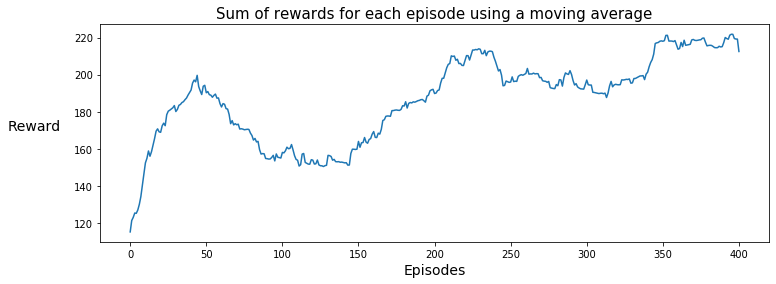

In [27]:
############################ PRINT BEST MODEL DATA ##############################
#plot(loaded['best_model_data']['loss'], [], '', 1, 100000, 'Loss', 'Learning Curve', 'Loss')
#plot(loaded['best_model_data']['episode_steps'], [], '', 1, 30, 'number of steps', 'Learning Curve', 'episode steps')
plot(loaded['best_model_data']['rewards'], [], '', 1, 100, 'Sum of rewards for each episode using a moving average', 'Episodes', 'Reward', clear=True)



In [28]:
env = gym.make('LunarLander-v2')

for _ in range(5):
    state = env.reset()
    for _ in range(300):
        env.render()
        state_tensor = tf.Variable(np.array([state]), dtype=tf.float32)
        action_values_tensor = network(state_tensor)
        action_values_proto_tensor = tf.make_tensor_proto(action_values_tensor)
        action_values = tf.make_ndarray(action_values_proto_tensor)
        action = argmax(action_values, np.random)
        print('action :', action)
        state, reward, is_terminal, _ = env.step(action) # take a random action
    
env.close()


action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 3
action : 3
action : 3
action : 3
action : 3
action : 1
action : 3
action : 3
action : 1
action : 3
action : 2
action : 2
action : 3
action : 2
action : 2
action : 2
action : 3
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 2
action : 3
action : 2
action : 2
action : 2
action : 3
action : 2
action : 2
action : 2
action : 2
action : 3
action : 2
action : 2
action : 2
action : 3
action : 2
action : 2
action : 2
action : 2
action : 2
action : 3
action : 2
action : 2
action : 2
action : 2
action : 2
action : 3
action : 2
action : 2
action : 2
action : 2
action : 3
action : 2
action : 2
action : 2
action : 2
action : 2
action : 3
action : 2

Exception ignored in: <function ScopedTFGraph.__del__ at 0x000002265F877488>
Traceback (most recent call last):
  File "C:\Users\a\Anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 52, in __del__
    c_api.TF_DeleteGraph(self.graph)
KeyboardInterrupt


action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 0
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 1
action : 3
action : 3
action : 3
action : 3
action : 3
action : 3
action : 3
action : 3
action : 1
action : 3
action : 3
action : 1
action : 3
action : 3
action : 3
action : 1
action : 3
action : 1
action : 3
action : 1
action : 3
action : 3
action : 1
action : 3
action : 1
action : 1
action : 3
action : 1
action : 1
action : 3
action : 1